# Exploratory data analysis

Notebook to look for features to predict home prices.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from math import ceil

Function to remove the seasonality (numpy array).

In [2]:
def remove_seasonality(data):
    """
    Function to remove the seasonality from a 1D numpy array
    """
    data_extend = np.concatenate([np.array([data[0]] * 6), data, np.array([data[-1]] * 6)])
    weights = np.array([0.5] + [1] * 11 + [0.5]) / 12
    m = np.convolve(data_extend, weights, 'valid')
    data_demean = data - m
    N = int(ceil(len(data_demean) / 12)) * 12 - len(data_demean)
    data_demean = np.concatenate([data_demean, np.repeat(np.nan, N)])
    deviations = np.reshape(data_demean, (-1, 12)).transpose()
    deviations = np.nanmean(deviations, axis=1)
    deviations = deviations - np.mean(deviations)
    N = int(ceil(len(data_demean) / 12))
    s = np.tile(deviations, N)[0:len(data)]
    data_sa = data - s
    return data_sa

Function to compute the correlation.

In [3]:
def rolling_corr(target, feature, N):
    df = pd.merge(target, feature, on=['date'], how='inner')
    target = df['United States_x'].to_numpy()
    feature = df['United States_y'].to_numpy()
    corr = np.zeros(N + 1)
    for i in range(0, N + 1):
        if i == 0:
            corr[i] = np.corrcoef(target, feature)[0, 1]
        else:
            corr[i] = np.corrcoef(target[i:], feature[0:-i])[0, 1]
    return corr

## Target

In [4]:
target = pd.read_csv('home_prices_raw.csv')
target = target.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
target = target.rename(columns={'RegionName':'index'})
target = target.set_index('index')
target = target.stack().unstack(level=0)
target = target.reset_index()
target = target.rename(columns={'index': 'date'})
target['date'] = pd.to_datetime(target['date'])
target = target.sort_values(['date'])
date = target['date']
target_growth = target.drop(columns=['date']).pct_change()
target['date'] = date
target_growth['date'] = date
target_growth = target_growth.iloc[1:]
target_growth_sa = target_growth[['date', 'United States']]
target_growth_sa['United States'] = remove_seasonality(target_growth_sa['United States'].to_numpy())

/opt/anaconda3/envs/ntpp/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Sales count

In [5]:
sales = pd.read_csv('sales_raw.csv')
sales = sales.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
sales = sales.rename(columns={'RegionName':'index'})
sales = sales.set_index('index')
sales = sales.stack().unstack(level=0)
sales = sales.reset_index()
sales = sales.rename(columns={'index': 'date'})
sales['date'] = pd.to_datetime(sales['date'])
sales = sales.sort_values(['date'])
sales_sa = sales[['date', 'United States']]
sales_sa['United States'] = remove_seasonality(sales_sa['United States'].to_numpy())

/opt/anaconda3/envs/ntpp/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Non-seasonally adjusted data.

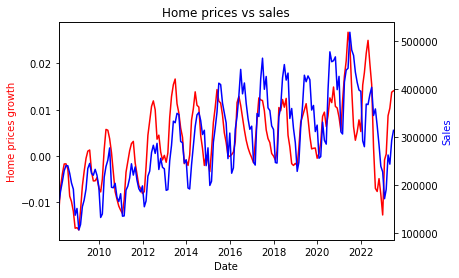

In [6]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth['date'], target_growth['United States'], 'r-') 
  
plt.title('Home prices vs sales')
ax1.set_xlim([max(target_growth['date'].min(), sales['date'].min()), \
          min(target_growth['date'].max(), sales['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Sales', color = 'blue') 
ax2.plot(sales['date'], sales['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and sales')

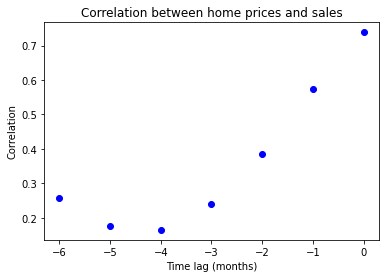

In [7]:
my_corr = rolling_corr(target_growth[['date', 'United States']],
                       sales[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and sales')

Seasonally adjusted data.

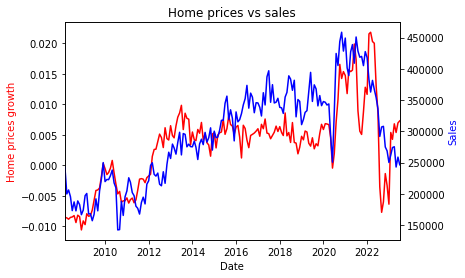

In [8]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth_sa['date'], target_growth_sa['United States'], 'r-') 
  
plt.title('Home prices vs sales')
ax1.set_xlim([max(target_growth_sa['date'].min(), sales_sa['date'].min()), \
          min(target_growth_sa['date'].max(), sales_sa['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Sales', color = 'blue') 
ax2.plot(sales_sa['date'], sales_sa['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and sales')

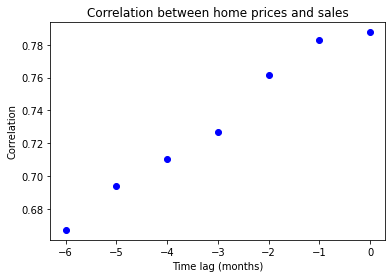

In [9]:
my_corr = rolling_corr(target_growth_sa[['date', 'United States']],
                       sales_sa[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and sales')

## Home inventory

In [10]:
inventory = pd.read_csv('inventory_raw.csv')
inventory = inventory.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
inventory = inventory.rename(columns={'RegionName':'index'})
inventory = inventory.set_index('index')
inventory = inventory.stack().unstack(level=0)
inventory = inventory.reset_index()
inventory = inventory.rename(columns={'index': 'date'})
inventory['date'] = pd.to_datetime(inventory['date'])
inventory = inventory.sort_values(['date'])
inventory_sa = inventory[['date', 'United States']]
inventory_sa['United States'] = remove_seasonality(inventory_sa['United States'].to_numpy())

/opt/anaconda3/envs/ntpp/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Non-seasonally adjusted data.

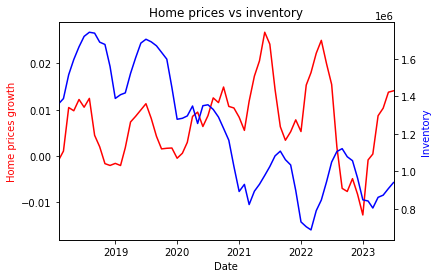

In [11]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth['date'], target_growth['United States'], 'r-') 
  
plt.title('Home prices vs inventory')
ax1.set_xlim([max(target_growth['date'].min(), inventory['date'].min()), \
          min(target_growth['date'].max(), inventory['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Inventory', color = 'blue') 
ax2.plot(inventory['date'], inventory['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and inventory')

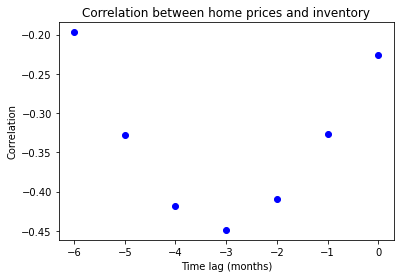

In [12]:
my_corr = rolling_corr(target_growth[['date', 'United States']],
                       inventory[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and inventory')

Seasonally adjusted data.

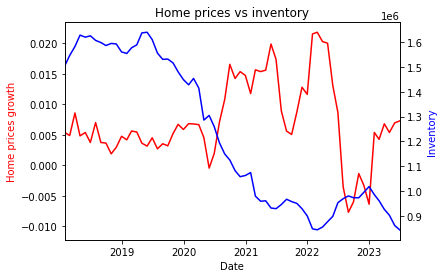

In [13]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth_sa['date'], target_growth_sa['United States'], 'r-') 
  
plt.title('Home prices vs inventory')
ax1.set_xlim([max(target_growth_sa['date'].min(), inventory_sa['date'].min()), \
          min(target_growth_sa['date'].max(), inventory_sa['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('Inventory', color = 'blue') 
ax2.plot(inventory_sa['date'], inventory_sa['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and inventory')

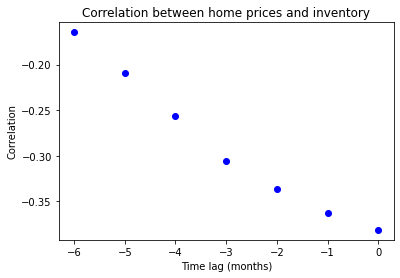

In [14]:
my_corr = rolling_corr(target_growth_sa[['date', 'United States']],
                       inventory_sa[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and inventory')

## New listings

In [15]:
new_listings = pd.read_csv('new_listings_raw.csv')
new_listings = new_listings.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])
new_listings = new_listings.rename(columns={'RegionName':'index'})
new_listings = new_listings.set_index('index')
new_listings = new_listings.stack().unstack(level=0)
new_listings = new_listings.reset_index()
new_listings = new_listings.rename(columns={'index': 'date'})
new_listings['date'] = pd.to_datetime(new_listings['date'])
new_listings = new_listings.sort_values(['date'])
new_listings_sa = new_listings[['date', 'United States']]
new_listings_sa['United States'] = remove_seasonality(new_listings_sa['United States'].to_numpy())

/opt/anaconda3/envs/ntpp/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Non-seasonally adjusted data.

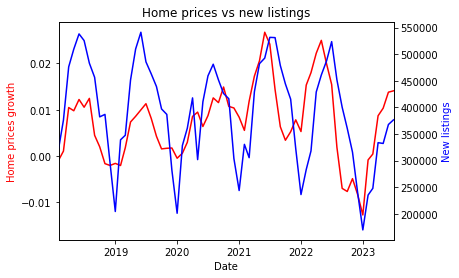

In [16]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth['date'], target_growth['United States'], 'r-') 
  
plt.title('Home prices vs new listings')
ax1.set_xlim([max(target_growth['date'].min(), new_listings['date'].min()), \
          min(target_growth['date'].max(), new_listings['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('New listings', color = 'blue') 
ax2.plot(new_listings['date'], new_listings['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and new listings')

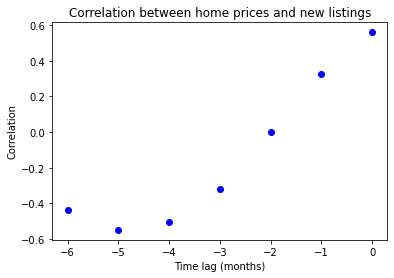

In [17]:
my_corr = rolling_corr(target_growth[['date', 'United States']],
                       new_listings[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and new listings')

Seasonally adjusted data.

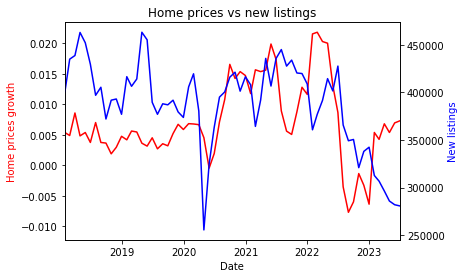

In [18]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Date') 
ax1.set_ylabel('Home prices growth', color = 'red') 
ax1.plot(target_growth_sa['date'], target_growth_sa['United States'], 'r-') 
  
plt.title('Home prices vs new listings')
ax1.set_xlim([max(target_growth_sa['date'].min(), new_listings_sa['date'].min()), \
          min(target_growth_sa['date'].max(), new_listings_sa['date'].max())])

ax2 = ax1.twinx() 
ax2.set_ylabel('New listings', color = 'blue') 
ax2.plot(new_listings_sa['date'], new_listings_sa['United States'], 'b-') 

plt.show()

Text(0.5, 1.0, 'Correlation between home prices and new listings')

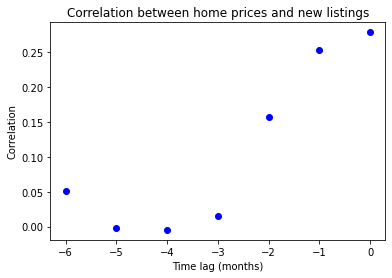

In [19]:
my_corr = rolling_corr(target_growth_sa[['date', 'United States']],
                       new_listings_sa[['date', 'United States']], 6)
plt.plot(np.arange(-6, 1), np.flip(my_corr), 'bo')
plt.xlabel('Time lag (months)')
plt.ylabel('Correlation')
plt.title('Correlation between home prices and new listings')